# Incubator State Estimation with a Particle Filter

Next we contruct the kalman filter, using the system sympy library to transform the system symbolic equations to a discrete time system.
We adjust the equations from [ModellingIncubatorDynamics](../3-Physics-Modelling/2-ModellingIncubatorDynamics.ipynb).

In [1]:
import sympy as sp
import numpy as np

import sympy as sp
import numpy as np

# Parameters
C_air = sp.Symbol("C_air", real=True)  # Specific heat capacity
G_box = sp.Symbol("G_box", real=True)  # Specific heat capacity
C_heater = sp.Symbol("C_heater", real=True)  # Specific heat capacity
G_heater = sp.Symbol("G_heater", real=True)  # Specific heat capacity

# Constants
V_heater = sp.Symbol("V_heater", real=True)
i_heater = sp.Symbol("i_heater", real=True)

# Inputs
in_room_temperature = sp.Symbol("T_room", real=True)
on_heater = sp.Symbol("on_heater", real=True)

# States
T = sp.Symbol("T", real=True)
T_heater = sp.Symbol("T_heater", real=True)

power_in = on_heater * V_heater * i_heater

power_transfer_heat = G_heater * (T_heater - T)

total_power_heater = power_in - power_transfer_heat

power_out_box = G_box * (T - in_room_temperature)

total_power_box = power_transfer_heat - power_out_box

der_T_heater = (1.0 / C_heater) * (total_power_heater)
der_T = (1.0 / C_air) * (total_power_box)

# Vectorize der_T and der_T_heater so they can be applied to the particles
der_T_heater_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T_heater)
der_T_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T)

In [2]:
# System parameters
V_heater_num = HEATER_VOLTAGE = 12.0
i_heater_num = HEATER_CURRENT = 10.45
C_air_num = 68.21
G_box_num = 0.74 
C_heater_num = 243.46
G_heater_num = 0.87

In [4]:
from data_handling import load_data
import pandas
import math

# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    HEATER_VOLTAGE, HEATER_CURRENT,
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=False,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,timestamp_ns,power_in,avg_temp_kelvin,potential_energy,lid_open
0,1.611327e+09,21.312,1611326936960770000,25.000,1611326937840280000,24.812,1611326938720290000,24.9060,False,False,3,2.617681,2021-01-22 14:48:58.720290,0.0,298.0560,0.000,0.0
1,1.611327e+09,21.312,1611326940000310000,25.000,1611326940880730000,24.875,1611326941760290000,24.9375,False,False,3,2.657222,2021-01-22 14:49:01.760290,0.0,298.0875,0.882,0.0
2,1.611327e+09,21.312,1611326942960290000,25.000,1611326943840300000,24.812,1611326944720280000,24.9060,False,False,3,2.616798,2021-01-22 14:49:04.720280,0.0,298.0560,0.000,0.0
3,1.611327e+09,21.312,1611326946000330000,25.000,1611326946880260000,24.812,1611326947760260000,24.9060,False,False,3,2.656322,2021-01-22 14:49:07.760260,0.0,298.0560,0.000,0.0
4,1.611327e+09,21.312,1611326948960360000,25.000,1611326949840270000,24.812,1611326950720280000,24.9060,True,True,3,2.615920,2021-01-22 14:49:10.720280,125.4,298.0560,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1.611328e+09,21.375,1611328323200280000,34.375,1611328324090060000,30.750,1611328324960250000,32.5625,False,True,3,2.661163,2021-01-22 15:12:04.960250,0.0,305.7125,214.382,0.0
463,1.611328e+09,21.437,1611328326160300000,34.750,1611328327039630000,31.000,1611328327920250000,32.8750,False,True,3,2.620764,2021-01-22 15:12:07.920250,0.0,306.0250,223.132,0.0
464,1.611328e+09,21.437,1611328329200330000,35.062,1611328330080280000,31.250,1611328330960280000,33.1560,False,True,3,2.660336,2021-01-22 15:12:10.960280,0.0,306.3060,231.000,0.0
465,1.611328e+09,21.437,1611328332160320000,35.375,1611328333040270000,31.562,1611328333920260000,33.4685,False,True,3,2.619904,2021-01-22 15:12:13.920260,0.0,306.6185,239.750,0.0


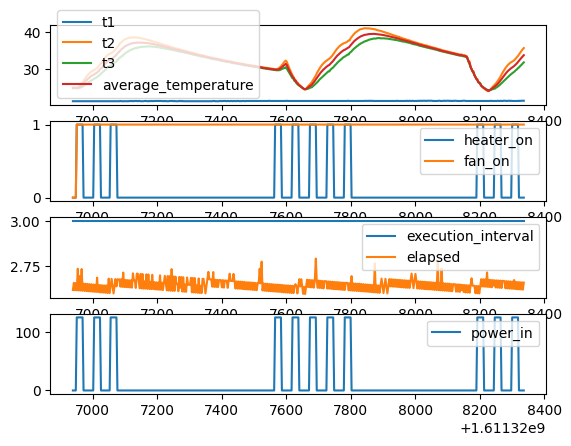

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(data["time"], data["t1"], label="t1")
ax1.plot(data["time"], data["t2"], label="t2")
ax1.plot(data["time"], data["t3"], label="t3")
ax1.plot(data["time"], data["average_temperature"], label="average_temperature")
ax1.legend()

ax2.plot(data["time"], data["heater_on"], label="heater_on")
ax2.plot(data["time"], data["fan_on"], label="fan_on")
ax2.legend()

ax3.plot(data["time"], data["execution_interval"], label="execution_interval")
ax3.plot(data["time"], data["elapsed"], label="elapsed")
ax3.legend()

ax4.plot(data["time"], data["power_in"], label="power_in")
ax4.legend()

In [6]:
events

,time,event,timestamp_ns
0,1611327598000000000,Lid Opened,2021-01-22 14:59:58
1,1611327658000000000,Lid Closed,2021-01-22 15:00:58
2,1611328159000000000,Lid Opened,2021-01-22 15:09:19
3,1611328225000000000,Lid Closed,2021-01-22 15:10:25


In [28]:
# Inputs to _plant
measurements_heater = np.array([1.0 if b else 0.0 for b in data["heater_on"]])
measurements_Troom = data["t1"].to_numpy()

# System state measurements (partial)
measurements_T = data["average_temperature"].to_numpy()

# Initial particles. Each particle represents a possible system state.
particles = np.zeros((10, 2))
particles[:, 0] = measurements_T[0]  # Initial heater temperature
particles[:, 1] = measurements_T[0]  # Initial box temperature
particles

array([[24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906],
       [24.906, 24.906]])

In [29]:
# Show how vectorized functions work:
der_T_heater_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[0], measurements_heater[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
# Main simulation loop

# results

results = np.zeros((len(data['time']), 2))

for step in range(len(data['time'])):
    results[step, 0] = np.mean(particles[:, 0]) # heater temperature
    results[step, 1] = np.mean(particles[:, 1]) # box temperature

    dt = data['time'][step] - data['time'][step - 1] if step > 0 else 3.0
    particles[:, 0] += der_T_heater_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[step], measurements_heater[step])*dt

    # note that we're using the updated heater temperature here. Slightly different numerical method but simple to write.
    particles[:, 1] += der_T_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[step], measurements_heater[step])*dt

results

array([[24.906     , 24.906     ],
       [24.906     , 24.78902771],
       [24.90472928, 24.67883984],
       [24.90233995, 24.57916024],
       [24.89882914, 24.48380325],
       [26.41906957, 24.45501226],
       [28.00409187, 24.48985858],
       [29.45144441, 24.57283043],
       [30.98407807, 24.71572532],
       [32.42278631, 24.89495251],
       [33.9458884 , 25.133855  ],
       [35.33876227, 25.389333  ],
       [35.2306888 , 25.63642772],
       [35.12920509, 25.85595015],
       [35.02846614, 26.06174695],
       [34.93362092, 26.24416833],
       [34.83921194, 26.41479224],
       [34.75011431, 26.5656002 ],
       [34.66120248, 26.7062362 ],
       [34.57705905, 26.83016787],
       [34.49290158, 26.94529362],
       [34.41306643, 27.04633256],
       [34.33303875, 27.13974886],
       [35.78158144, 27.27886936],
       [37.25502959, 27.46889714],
       [38.67624712, 27.69432295],
       [40.14171979, 27.97003552],
       [41.51905602, 28.26380451],
       [42.94054376,

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotly_incubator_data(data, compare_to=None, heater_T_data=None, events=None,
                          overlay_heater=True, show_actuators=False, show_sensor_temperatures=False,
                          show_hr_time=False):
    nRows = 2
    titles = ["Incubator Temperature (°C)", "Room Temperature (°C)"]
    if show_actuators:
        nRows += 1
        titles.append("Actuators")
    if heater_T_data is not None:
        nRows += 1
        titles.append("Heatbed Temperature (°C)")

    x_title = "Timestamp" if show_hr_time else "Time (s)"

    time_field = "timestamp_ns" if show_hr_time else "time"

    fig = make_subplots(rows=nRows, cols=1, shared_xaxes=True,
                        x_title=x_title,
                        subplot_titles=titles)

    if show_sensor_temperatures:
        fig.add_trace(go.Scatter(x=data[time_field], y=data["t2"], name="t2 (right)"), row=1, col=1)
        fig.add_trace(go.Scatter(x=data[time_field], y=data["t3"], name="t3 (top)"), row=1, col=1)

    fig.add_trace(go.Scatter(x=data[time_field], y=data["average_temperature"], name="avg_T", 
                            #  error_y={
                            #         "type" : 'constant',
                            #         "value" : std_dev_measurement_noise,
                            #     }
                            ), 
                  row=1, col=1)
    if overlay_heater:
        fig.add_trace(go.Scatter(x=data[time_field], y=[40 if b else 30 for b in data["heater_on"]], name="heater_on"), row=1, col=1)

    if events is not None:
        for i, r in events.iterrows():
            # Get the closest timestamp_ns to the event time
            closest_ts = min(data[time_field], key=lambda x:abs(x-r[time_field]))
            # Get the average temperature for that timestamp_ns
            avg_temp = data.iloc[data.index[data[time_field] == closest_ts]]["average_temperature"].iloc[0]

            fig.add_annotation(x=r[time_field], y=avg_temp,
                               text=r["event"],
                               showarrow=True,
                               arrowhead=1)

    if compare_to is not None:
        for res in compare_to:
            if "T" in compare_to[res]:
                fig.add_trace(go.Scatter(x=compare_to[res][time_field], 
                                         y=compare_to[res]["T"],
                                        #  error_y={
                                        #     "type" : 'data',
                                        #     "array" : kalman_process_noise_T,
                                        #  },
                                         name=f"avg_temp({res})"), row=1, col=1)
                # fig.add_trace(go.Scatter(x=compare_to[res][time_field], 
                #                          y=kalman_prediction_prior_T,
                #                          error_y={
                #                             "type" : 'data',
                #                             "array" : kalman_process_noise_T_prior,
                #                          },
                #                          name=f"avg_temp_prior({res})"), row=1, col=1)
            if "T_object" in compare_to[res]:
                fig.add_trace(go.Scatter(x=compare_to[res][time_field], y=compare_to[res]["T_object"], name=f"T_object({res})"), row=1, col=1)

    fig.add_trace(go.Scatter(x=data[time_field], y=data["t1"], name="room", 
                            #  error_y={
                            #         "type" : 'constant',
                            #         "value" : std_dev_measurement_noise,
                            #     }
                            ), 
                  row=2, col=1)

    next_row = 3

    if show_actuators:
        fig.add_trace(go.Scatter(x=data[time_field], y=data["heater_on"], name="heater_on"), row=next_row, col=1)
        fig.add_trace(go.Scatter(x=data[time_field], y=data["fan_on"], name="fan_on"), row=next_row, col=1)

        if compare_to is not None:
            for res in compare_to:
                if "in_lid_open" in compare_to[res]:
                    fig.add_trace(go.Scatter(x=compare_to[res][time_field], y=compare_to[res]["in_lid_open"], name=f"in_lid_open({res})"), row=next_row, col=1)

        next_row += 1

    if heater_T_data is not None:
        for trace in heater_T_data:
            fig.add_trace(go.Scatter(x=heater_T_data[trace][time_field], y=heater_T_data[trace]["T_heater"],
                                     name=f"T_heater({trace})", 
                                    #  error_y={
                                    #     "type" : 'data',
                                    #     "array" : kalman_process_noise_Theater,
                                    # }
                                    ), 
                                    row=next_row, col=1)
        next_row += 1

    fig.update_layout()

    return fig



In [32]:
fig = plotly_incubator_data(data,
                            compare_to={
                                "PF": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T": results[:, 1]
                                },
                            },
                            heater_T_data={
                                "PF": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T_heater": results[:, 0]
                                },
                            },
                            events=events,
                            overlay_heater=True,
                            show_hr_time=True)

# Save plotly interactive plot
import plotly.io as pio
pio.write_html(fig, file="incubator_PF.html")

fig